In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

### 패키지 설치 & 라이브러리 import

In [20]:
!pip install optuna
!pip uninstall torchsummary
!pip install torchinfo

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [22]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [23]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [24]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [25]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [26]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(X, y):

    #Train, Test 분류
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Train, Validation 분류
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


    # 데이터 크기 출력
    print("Train set:", X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, y_val.shape)
    print("Test set:", X_test.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [27]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

## 전처리

### 1. 데이터셋 가져오기

In [28]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

In [29]:
# 데이터셋 출력
# raw

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [30]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- LSTM을 사용한 모델 클래스 선언
- 구조 : LSTM + Fully Connected Layer

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna

# LSTM 모델 클래스 정의
class LSTM_Model(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, output_size=3):
        super(LSTM_Model, self).__init__()

        # hidden state size
        self.hidden_size = hidden_size

        # LSTM layer 수
        self.num_layers = num_layers

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):


        # LSTM hidden state, cell state 초기화
        # 초기 hidden state와 cell state 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)


        # LSTM 레이어를 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시점의 hidden state에서 Fully Connected Layer를 통과
        out = self.fc(out[:, -1, :])

        return out

In [32]:
# 목적 함수 정의
def objective(trial, tri, batch_size, sequence_length):
    # 하이퍼파라미터 탐색 공간 정의
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    #learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    # batch_size = trial.suggest_int("batch_size", 16, 64)
    learning_rate = 1e-3

    num_epochs = 10

    input_size = 3 #lat, lon, alt
    output_size = 3  #lat, lon, alt

    # 데이터셋 로더
    train_loader, val_loader, _ = create_dataloaders(tri, batch_size, sequence_length)

    # 모델 정의: LSTMModel
    model = LSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    # epoch 따로 빼기
    # 모델 학습

    for epoch in range(num_epochs):  # 10 에포크 동안 학습
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            # 입력 데이터의 차원을 맞추기 위해 (batch_size, 1, input_size) 형태로 변환

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    # Validation set에서 성능 측정
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # Optuna에 검증 손실 리포트
    trial.report(val_loss, epoch)

    # Early stopping 조건
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_loss
    # return val_loss / len(val_loader)

## 학습

### 1. 데이터 준비

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

In [33]:
### 같이 수정 필요

# 데이터 준비
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  train_x, train_y = create_sequences(tri[['lat', 'lon', 'alt']], sequence_length)

  X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(train_x, train_y)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [34]:
batch_size = 32
sequence_length = 10

### 2. 최적의 하이퍼파라미터 탐색

#### 1. 하이퍼 파라미터 탐색

In [35]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, tri, batch_size, sequence_length), n_trials=1)


# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-09-27 05:42:29,331] A new study created in memory with name: no-name-55fdaf45-b710-4e53-8178-1ea0733acff4


Train set: (3250, 10, 3) (3250, 3)
Validation set: (1084, 10, 3) (1084, 3)
Test set: (1084, 10, 3) (1084, 3)


[I 2024-09-27 05:42:51,333] Trial 0 finished with value: 0.0044276766893744934 and parameters: {'hidden_size': 103, 'num_layers': 1}. Best is trial 0 with value: 0.0044276766893744934.


Best hyperparameters:  {'hidden_size': 103, 'num_layers': 1}


#### 2. 하이퍼파라미터 저장

In [36]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


#### 3. 하이퍼파라미터 불러오기

In [37]:
import json

# 1. 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'hidden_size': 103, 'num_layers': 1}


### 3. 최적의 파라미터로 모델 학습

In [38]:
# 최적의 모델 학습
best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, batch_size, sequence_length)

best_model = LSTM_Model(input_size=3, hidden_size=best_params['hidden_size'],
                      num_layers=best_params['num_layers'], output_size=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

Train set: (3250, 10, 3) (3250, 3)
Validation set: (1084, 10, 3) (1084, 3)
Test set: (1084, 10, 3) (1084, 3)


In [39]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

num_epochs = 1
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        print(batch_x.shape)

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    model_save_path = f"best_model_epoch_{epoch+1}.pth"
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{50} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 

In [40]:
!pip install torchinfo

In [41]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               [1, 3]                    --
├─LSTM: 1-1                              [1, 10, 103]              44,496
├─Linear: 1-2                            [1, 3]                    312
Total params: 44,808
Trainable params: 44,808
Non-trainable params: 0
Total mult-adds (M): 0.45
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.18
Estimated Total Size (MB): 0.19

## 테스트

### 1. 테스트 결과 생성

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 0.0028874718118458986
Mean Absolute Error (MAE): 0.03943075239658356


### 2. 결과 시각화

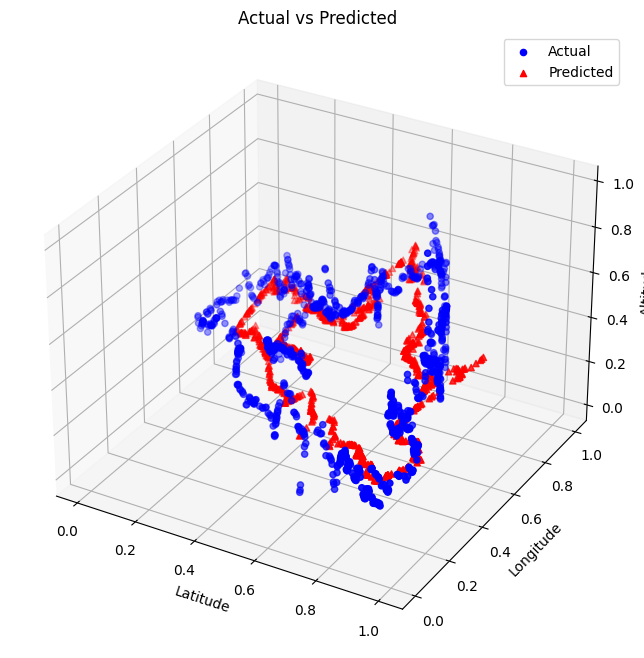

In [43]:
prediction_visualization(y_true, y_pred)

Todo
- min max scaling 풀어서, raw랑 찍어보기
- epoch이랑 batch, learning rate 찍어보기
- 파라미터 수 측정
- 모델 구조 출려 코드

#### 3. raw 데이터와 predict 데이터 비교

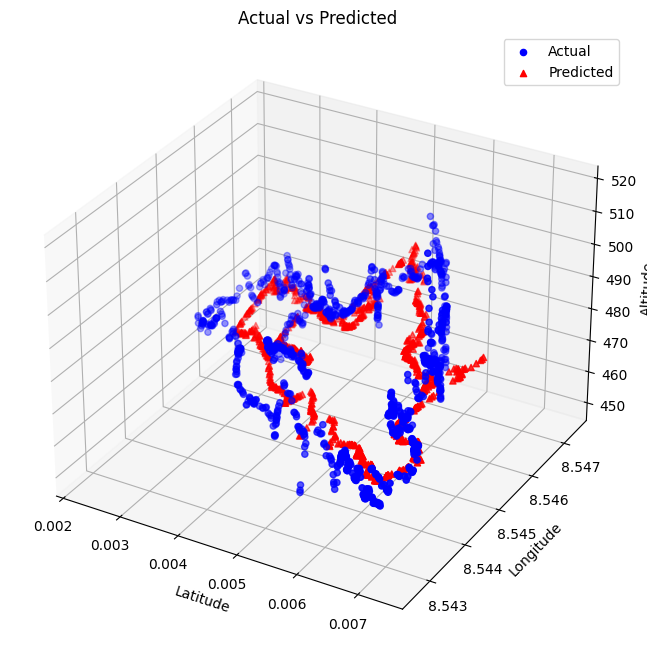

In [44]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)